<a href="https://colab.research.google.com/github/selcuk-yalcin/TrustworthyML/blob/main/Nested_Crossvalidation_Score_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
# Load dataset
X, y = load_iris(return_X_y=True)
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [ ]:
# Step 1: Split the dataset — Outer CV loop (for estimating generalization)
K = 3  # Number of outer folds
outer_cv = KFold(n_splits=K, shuffle=True, random_state=42)
outer_scores = []
outer_fold_indices = []
all_inner_scores = []

In [ ]:
# Step 2: Outer loop for generalization estimation
for fold_idx, (outer_trainval_idx, outer_test_idx) in enumerate(outer_cv.split(X), 1):
    X_trainval, X_test = X[outer_trainval_idx], X[outer_test_idx]
    y_trainval, y_test = y[outer_trainval_idx], y[outer_test_idx]

    # Inner loop for hyperparameter tuning
    L = 3  # Number of inner folds
    inner_cv = KFold(n_splits=L, shuffle=True, random_state=42)
    hyperparams = list(range(1, 11))  # Trying k from 1 to 10
    best_avg_score = -np.inf
    best_k = None
    inner_scores_for_k = []

    # Try each k value
    for k in hyperparams:
        inner_scores = []

        # Inner CV loop
        for inner_train_idx, inner_val_idx in inner_cv.split(X_trainval):
            X_inner_train, X_inner_val = X_trainval[inner_train_idx], X_trainval[inner_val_idx]
            y_inner_train, y_inner_val = y_trainval[inner_train_idx], y_trainval[inner_val_idx]

            model = KNeighborsClassifier(n_neighbors=k)
            model.fit(X_inner_train, y_inner_train)
            val_pred = model.predict(X_inner_val)
            acc = accuracy_score(y_inner_val, val_pred)
            inner_scores.append(acc)

        avg_val_score = np.mean(inner_scores)
        inner_scores_for_k.append(avg_val_score)

        if avg_val_score > best_avg_score:
            best_avg_score = avg_val_score
            best_k = k

    # Save inner results for plotting
    all_inner_scores.append(inner_scores_for_k)

    # Train with best hyperparameter on full trainval and evaluate on outer test set
    final_model = KNeighborsClassifier(n_neighbors=best_k)
    final_model.fit(X_trainval, y_trainval)
    test_pred = final_model.predict(X_test)
    test_score = accuracy_score(y_test, test_pred)
    outer_scores.append(test_score)
    outer_fold_indices.append(fold_idx)

In [ ]:
# Step 3: Final generalization score
final_score = np.mean(outer_scores)
print(f"Nested CV Final Generalization Accuracy: {final_score:.4f}")

Nested CV Final Generalization Accuracy: 0.9600


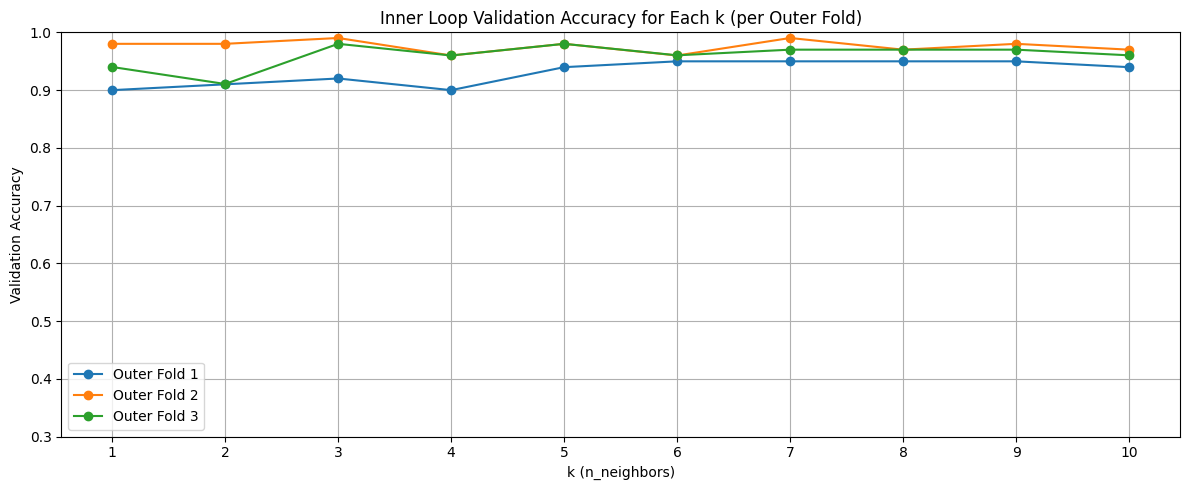

In [ ]:
#  Inner loop scores per outer fold
plt.figure(figsize=(12, 5))
for i, scores in enumerate(all_inner_scores):
    plt.plot(range(1, 11), scores, marker='o', label=f'Outer Fold {i+1}')
plt.title('Inner Loop Validation Accuracy for Each k (per Outer Fold)')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Validation Accuracy')
plt.xticks(range(1, 11))
plt.ylim(0.3, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

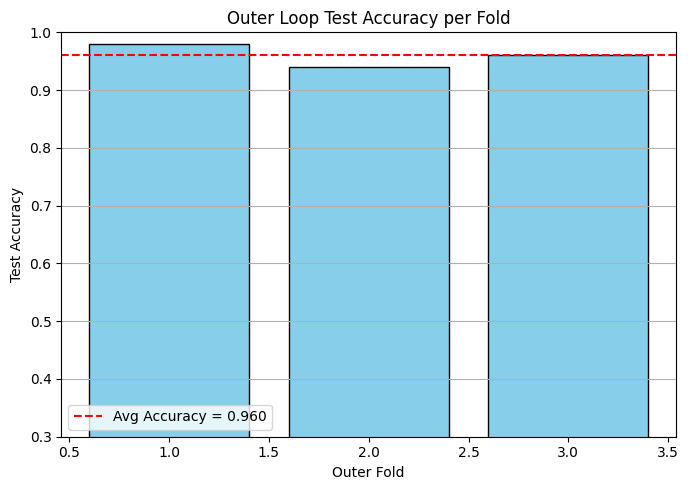

In [ ]:
#  Outer loop test scores
plt.figure(figsize=(7, 5))
plt.bar(outer_fold_indices, outer_scores, color='skyblue', edgecolor='black')
plt.axhline(y=final_score, color='red', linestyle='--', label=f'Avg Accuracy = {final_score:.3f}')
plt.title('Outer Loop Test Accuracy per Fold')
plt.xlabel('Outer Fold')
plt.ylabel('Test Accuracy')
plt.ylim(0.3, 1.0)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
print("Inner Scores:", inner_scores)
print("Outer Scores:", outer_scores)

Inner Scores: [0.9411764705882353, 0.9696969696969697, 0.9696969696969697]
Outer Scores: [0.98, 0.94, 0.96]
